In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from tqdm import tqdm_notebook

import umap
from sklearn.manifold import MDS

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn import ensemble

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import keras
import tensorflow as tf

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
path_data = Path('data/data_z/scores_and_z.txt')
path_images = Path('data\data_z\images_100_per_group')

data = pd.read_csv(path_data)

# data = data[data['group'] == '18_24m']  # '18_24m', '18_24f', '38_44m', '38_44f', '58_64m', '58_64f'
# data = data.drop(['group', 'file_name'], axis=1)
# data = data.reset_index(drop=True)

names_scores = ['valid', 'score_shape', 'score_abnormal', 'score_maxheat', 'score_symmetry', 'score_left2right']
names_z = ['z{}'.format(i) for i in range(128)]

print(data.shape)
data.head()

(60000, 136)


,file_name,group,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right,z0,z1,...,z118,z119,z120,z121,z122,z123,z124,z125,z126,z127
0,18_24m_0000000.png,18_24m,0,-0.102,0.808,-0.251,0.428,-0.675,-0.213015,-0.578981,...,0.027615,-0.762049,0.237476,-0.523285,0.730154,-0.657813,0.082598,-0.599990,-0.127278,0.937670
1,18_24m_0000001.png,18_24m,0,-0.236,0.838,0.370,-0.874,-2.474,-0.507453,0.511222,...,0.295520,0.290002,-0.080838,-0.361533,0.198909,-0.067757,-0.603348,0.865588,-0.926048,0.657332
2,18_24m_0000002.png,18_24m,0,-0.609,-0.998,-0.676,-9.650,-1.354,0.023033,0.482264,...,0.668171,0.149898,0.227095,0.689197,0.144303,-0.850887,-0.008787,0.018448,-0.727958,-0.660615
3,18_24m_0000003.png,18_24m,0,-0.420,-0.220,0.553,-0.028,0.366,0.681417,-0.064058,...,0.597393,-0.740091,-0.580335,-0.240965,0.053230,-0.260743,-0.566980,-0.435805,0.379895,0.656200
4,18_24m_0000004.png,18_24m,0,-0.007,-0.162,-1.000,0.560,0.819,0.351875,0.052275,...,0.348097,-0.884663,-0.923793,-0.906379,0.066671,-0.200955,-0.342336,-0.022683,0.774984,-0.089663


In [19]:
data.groupby('group')['valid'].value_counts(normalize=True)

group   valid
18_24f  0        0.9397
        1        0.0603
18_24m  0        0.9306
        1        0.0694
38_44f  0        0.9637
        1        0.0363
38_44m  0        0.9678
        1        0.0322
58_64f  0        0.9589
        1        0.0411
58_64m  0        0.9794
        1        0.0206
Name: valid, dtype: float64

,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.043317,-0.163849,0.003217,0.170201,-1.441515,-0.299450
std,0.203571,0.221203,0.647530,0.590855,2.381669,10.611759
min,0.000000,-1.496000,-1.000000,-1.000000,-37.000000,-2582.800000
25%,0.000000,-0.302000,-0.620000,-0.199000,-1.902000,-0.702250
50%,0.000000,-0.142000,0.058000,0.359000,-0.732000,0.041000
75%,0.000000,-0.004000,0.620000,0.654000,0.032000,0.552000
max,1.000000,0.489000,0.988000,0.999000,1.000000,1.000000


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
valid,1.000000,0.259087,0.216339,0.152048,0.170441,0.017922
score_shape,0.259087,1.000000,0.321058,0.280105,0.271647,0.038377
score_abnormal,0.216339,0.321058,1.000000,0.567984,0.240788,0.022292
score_maxheat,0.152048,0.280105,0.567984,1.000000,0.093406,0.003736
score_symmetry,0.170441,0.271647,0.240788,0.093406,1.000000,0.059781
score_left2right,0.017922,0.038377,0.022292,0.003736,0.059781,1.000000


valid


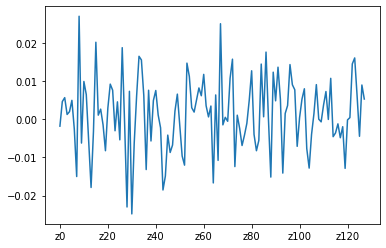

score_shape


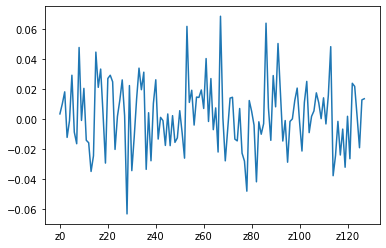

score_abnormal


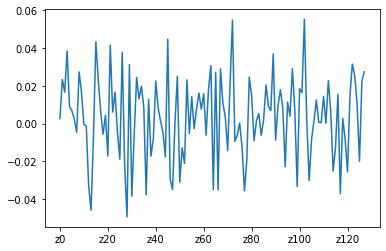

score_maxheat


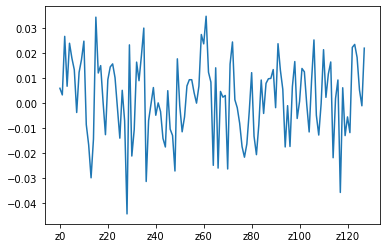

score_symmetry


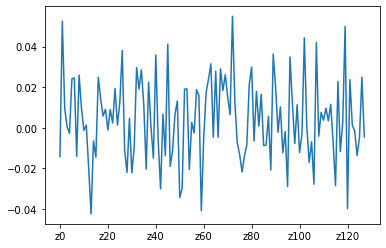

score_left2right


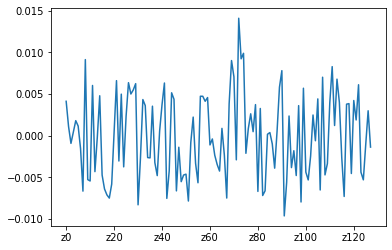

In [23]:
display(data[names_scores].describe())
display(data[names_scores].corr())

for name_score in names_scores:
    print(name_score)
    names = names_z + [name_score]
    c = data[names].corr()[name_score][:-1]
    c.plot();
    plt.show()

In [25]:
def get_splitted_data(name, p=0.2):
    sorted_df = data.sort_values(name)

    k = int(p * len(sorted_df))
    
    z_bad = sorted_df[:k][names_z].values
    z_good = sorted_df[-k:][names_z].values

    x = np.concatenate((z_bad, z_good))
    y = np.concatenate((np.zeros((len(z_bad), 1)), np.ones((len(z_good), 1))))

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y)


    hard_df = sorted_df[k:-k]

    x_test = hard_df[names_z]
    y_test = hard_df[[name]]

    y_test = (y_test > 0).values.astype(np.float32)
    
    return x_train, y_train, x_valid, y_valid, x_test, y_test


def get_splitted_data2(name, threshold=0):
    
    x = data[names_z].values
    y = data[[name]]
    
    y = (y > threshold).values.astype(np.float32)

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y)
    
    return x_train, y_train, x_valid, y_valid


def get_splitted_data3(name, threshold=0):
    
    sorted_df = data.sort_values(name)

    bad = sorted_df[sorted_df[name]<threshold]
    good = sorted_df[sorted_df[name]>=threshold]

    k = int(0.2 * len(sorted_df))
    bad = bad[:k]
#     bad = bad[-k:]
    
    z_bad = bad[names_z].values
    z_good = good[names_z].values

    x = np.concatenate((z_bad, z_good))
    y = np.concatenate((np.zeros((len(z_bad), 1)), np.ones((len(z_good), 1))))

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y)
    
    return x_train, y_train, x_valid, y_valid

In [5]:
%%time

classifiers = {
    
    'kNN1': KNeighborsClassifier(n_neighbors=1, algorithm='brute', n_jobs=-1),
    'kNN3': KNeighborsClassifier(n_neighbors=3, algorithm='brute', n_jobs=-1),
    'kNN10': KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    'kNN30': KNeighborsClassifier(n_neighbors=30, n_jobs=-1),
    
    'SCV_lin': svm.SVC(kernel='linear', probability=True),
    'SVC_rbf': svm.SVC(kernel='rbf', probability=True, gamma='auto'),
    'SVC_poly': svm.SVC(kernel='poly', probability=True, gamma='auto'),
    
    'LogReg.01': LogisticRegression(C=0.01, n_jobs=-1),
    'LogReg.1': LogisticRegression(C=0.1, n_jobs=-1),
    'LogReg.1_l1': LogisticRegression(C=0.1, penalty='l1', n_jobs=-1),
    'LogReg1': LogisticRegression(C=1.0, n_jobs=-1),
    'LogReg10': LogisticRegression(C=10.0, n_jobs=-1),
    
    'Tree5': tree.DecisionTreeClassifier(max_depth=5),
    'Tree10': tree.DecisionTreeClassifier(max_depth=10),
    
    'Forest': ensemble.RandomForestClassifier(n_jobs=-1),
}

results = []

for group in data['group'].unique():
    for name_score in names_scores:

        data_group = data[data['group'] == group]
        x = data_group[names_z]
        y = data_group[[name_score]]

        if name_score != 'valid':
            y = (y > 0)
        
        for name_cls, classifier in classifiers.items():
            print(f'\n{group} {name_score} {name_cls}')

            res = cross_validate(classifier, x, y, scoring=['precision', 'recall', 'accuracy', 'roc_auc'], cv=3, n_jobs=-1, verbose=0)

            precision = res['test_precision']
            recall = res['test_recall']
            accuracy = res['test_accuracy']
            roc_auc = res['test_roc_auc']
            print(f'{precision}\n{recall}\n{accuracy}\n{roc_auc}')
            
            results.append([group, name_score, name_cls, 
                            precision.mean(), recall.mean(), accuracy.mean(), roc_auc.mean()])
            
            
results = pd.DataFrame(results, columns=['group', 'score', 'cls', 'precision', 'recall', 'accuracy', 'roc_auc'])
results.to_csv('cls_res.csv', index=False)


18_24m valid kNN1
[0.0859375  0.08363636 0.1025641 ]
[0.09482759 0.0995671  0.13852814]
[0.86682663 0.8619862  0.85628563]
[0.50969619 0.50916459 0.5241319 ]

18_24m valid kNN3
[0.18367347 0.09859155 0.08139535]
[0.0387931  0.03030303 0.03030303]
[0.92111578 0.91359136 0.90909091]
[0.51841276 0.53787879 0.54103971]

18_24m valid kNN10
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.55889971 0.57474371 0.57260223]

18_24m valid kNN30
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.62260583 0.59361088 0.62893162]

18_24m valid SCV_lin
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.51087313 0.6025159  0.5634488 ]

18_24m valid SVC_rbf
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.72246493 0.71610831 0.72225711]

18_24m valid SVC_poly
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.68378299 0.66378904 0.69363433]

18_24m valid LogReg.01
[0. 0. 0.]
[0. 0. 0.]
[0.93041392 0.93069307 0.93069307]
[0.73057427 0.71976186 0.72947072]

[nan nan nan]

18_24m score_maxheat LogReg1
[0.75051688 0.75252701 0.7515528 ]
[0.92209992 0.91444303 0.92209992]
[0.72765447 0.72637264 0.72877288]
[0.70129764 0.70343397 0.69929261]

18_24m score_maxheat LogReg10
[0.75103448 0.75244073 0.75190311]
[0.92209992 0.91401948 0.91998307]
[0.72825435 0.72607261 0.72817282]
[0.70129198 0.70345925 0.69928912]

18_24m score_maxheat Tree5
[0.7120695  0.71231156 0.71343377]
[0.97163421 0.96060991 0.96232007]
[0.70155969 0.69726973 0.69936994]
[0.56030497 0.58309759 0.54951903]

18_24m score_maxheat Tree10
[0.71653543 0.72861469 0.72417795]
[0.80906012 0.81533249 0.79254869]
[0.63797241 0.65406541 0.63906391]
[0.53242548 0.54940254 0.5200874 ]

18_24m score_maxheat Forest
[0.70934776 0.70938628 0.70959976]
[0.99915326 0.99872935 0.99830652]
[0.70935813 0.70927093 0.70927093]
[0.63209058 0.61135077 0.60303436]

18_24m score_symmetry kNN1
[0.42537851 0.42339623 0.43343195]
[0.46640316 0.44382911 0.46360759]
[0.5584883  0.55985599 0.56675668]
[0.540

[0.60345561 0.60078041 0.62151715]

18_24f score_shape kNN30
[0.53846154 0.54285714 0.44      ]
[0.01701094 0.02311436 0.013382  ]
[0.75374925 0.75427543 0.75247525]
[0.66209311 0.67138459 0.67607612]

18_24f score_shape SCV_lin
[0.65566038 0.63414634 0.62580645]
[0.16889429 0.15815085 0.11800487]
[0.77294541 0.76987699 0.76507651]
[0.76294245 0.76394037 0.76484539]

18_24f score_shape SVC_rbf
[1. 1. 1.]
[0.0036452  0.00486618 0.00243309]
[0.75404919 0.75457546 0.7539754 ]
[0.77984644 0.78302719 0.78364345]

18_24f score_shape SVC_poly
[0. 0. 0.]
[0. 0. 0.]
[0.75314937 0.75337534 0.75337534]
[0.74451853 0.73855861 0.7422097 ]

18_24f score_shape LogReg.01
[0.63636364 0.60465116 0.62869198]
[0.2126367  0.18978102 0.18126521]
[0.77564487 0.76957696 0.77167717]
[0.7673043  0.76534538 0.77063693]

18_24f score_shape LogReg.1
[0.61238532 0.57073171 0.57512953]
[0.32442284 0.28467153 0.27007299]
[0.78254349 0.77077708 0.77077708]
[0.76790385 0.76519131 0.77062482]

18_24f score_shape LogReg.

[0.73676601 0.74054564 0.74040939]

18_24f score_symmetry LogReg.1_l1
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]

18_24f score_symmetry LogReg1
[0.59898477 0.62004175 0.61490683]
[0.46456693 0.46808511 0.46771654]
[0.67756449 0.68826883 0.68556856]
[0.73678508 0.74045936 0.74038496]

18_24f score_symmetry LogReg10
[0.59939148 0.62004175 0.61506708]
[0.46535433 0.46808511 0.46929134]
[0.67786443 0.68826883 0.68586859]
[0.73678813 0.74045363 0.74037733]

18_24f score_symmetry Tree5
[0.43141593 0.46367521 0.46711409]
[0.15354331 0.17100079 0.27401575]
[0.6004799  0.60906091 0.60426043]
[0.57684376 0.57493922 0.58360502]

18_24f score_symmetry Tree10
[0.43006993 0.43421053 0.42363112]
[0.38740157 0.33806147 0.34724409]
[0.57108578 0.58025803 0.57125713]
[0.5485137  0.5397325  0.55242194]

18_24f score_symmetry Forest
[0.57894737 0.63333333 0.64814815]
[0.07795276 0.0748621  0.08267717]
[0.62717457 0.63126313 0.63336334]
[0.64284872 0.64428688 0.660699  ]

18_24f score_left2rig

[0.66413059 0.66017995 0.66482185]

38_44m score_abnormal SCV_lin
[0.70612731 0.70241785 0.68571429]
[0.7198302  0.6875     0.69902913]
[0.71325735 0.70147015 0.69276928]
[0.78527765 0.762872   0.76007678]

38_44m score_abnormal SVC_rbf
[0.71693597 0.70708955 0.69501823]
[0.72650091 0.68992718 0.69417476]
[0.72285543 0.70537054 0.69816982]
[0.79284739 0.77113631 0.76636657]

38_44m score_abnormal SVC_poly
[0. 0. 0.]
[0. 0. 0.]
[0.50539892 0.50555056 0.50555056]
[0.77349675 0.75518207 0.75157335]

38_44m score_abnormal LogReg.01
[0.71637249 0.7037037  0.68231047]
[0.71376592 0.68021845 0.6881068 ]
[0.71865627 0.70027003 0.68736874]
[0.78578367 0.76524229 0.76023595]

38_44m score_abnormal LogReg.1
[0.7146312  0.70150188 0.68105516]
[0.71679806 0.68021845 0.68932039]
[0.71835633 0.69876988 0.68676868]
[0.78610038 0.76505287 0.76015852]

38_44m score_abnormal LogReg.1_l1
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]

38_44m score_abnormal LogReg1
[0.71549637 0.70206121 0.6808638

[0.62031451 0.59348717 0.62103965]

38_44m score_left2right LogReg10
[0.55063291 0.53744076 0.54359926]
[0.41344196 0.38519022 0.39782756]
[0.59178164 0.58205821 0.58625863]
[0.62033311 0.59348607 0.62103892]

38_44m score_left2right Tree5
[0.47450111 0.4849921  0.49441101]
[0.43584521 0.20855978 0.39035981]
[0.5374925  0.55265527 0.55415542]
[0.53624492 0.51897939 0.5310076 ]

38_44m score_left2right Tree10
[0.47085541 0.45172414 0.46504783]
[0.42226748 0.44497283 0.42905635]
[0.53509298 0.51635164 0.52955296]
[0.5161397  0.50942654 0.51573083]

38_44m score_left2right Forest
[0.49907919 0.50479846 0.52941176]
[0.18397828 0.17866848 0.19551935]
[0.55788842 0.55985599 0.56765677]
[0.55370829 0.56744508 0.57046715]

38_44f valid kNN1
[0.09677419 0.06666667 0.04494382]
[0.09917355 0.09090909 0.0661157 ]
[0.93371326 0.92079208 0.91509151]
[0.53215758 0.52148194 0.50659459]

38_44f valid kNN3
[0.05555556 0.03703704 0.0625    ]
[0.00826446 0.00826446 0.01652893]
[0.95890822 0.95619562 0.955

[0.55735402 0.50302675 0.49969363]

58_64m valid Forest
[0. 0. 0.]
[0. 0. 0.]
[0.97930414 0.97959796 0.97929793]
[0.517105   0.57048689 0.52738038]

58_64m score_shape kNN1
[0.19269103 0.22920204 0.23274478]
[0.20640569 0.24021352 0.25800712]
[0.72045591 0.73567357 0.73147315]
[0.51554051 0.53818688 0.54275311]

58_64m score_shape kNN3
[0.24295775 0.26689189 0.24025974]
[0.1227758 0.1405694 0.1316726]
[0.78764247 0.789979   0.78337834]
[0.56454639 0.57742975 0.5772172 ]

58_64m score_shape kNN10
[0.32       0.52173913 0.375     ]
[0.01423488 0.02135231 0.01067616]
[0.82873425 0.83168317 0.83018302]
[0.61410945 0.6373295  0.61538578]

58_64m score_shape kNN30
[0. 1. 0.]
[0.         0.00355872 0.        ]
[0.83143371 0.8319832  0.83138314]
[0.69593142 0.71280554 0.66919037]

58_64m score_shape SCV_lin
[0.         0.         0.66176471]
[0.         0.         0.16014235]
[0.83143371 0.83138314 0.84458446]
[0.82515868 0.81567801 0.80627136]

58_64m score_shape SVC_rbf
[0. 0. 0.]
[0. 0. 0.]

[0.69200868 0.69927873 0.69277251]

58_64f score_abnormal kNN1
[0.53815261 0.54057079 0.5600907 ]
[0.56608328 0.58298129 0.5962583 ]
[0.54289142 0.54635464 0.56645665]
[0.54302972 0.54656224 0.56662557]

58_64f score_abnormal kNN3
[0.55964912 0.55185185 0.56636156]
[0.57754979 0.62945081 0.5974653 ]
[0.56418716 0.56165617 0.57245725]
[0.57816912 0.5776697  0.58918049]

58_64f score_abnormal kNN10
[0.6056338  0.59948153 0.60272011]
[0.51901026 0.55823778 0.50814725]
[0.5929814 0.5949595 0.5889589]
[0.6213597  0.62595674 0.61783902]

58_64f score_abnormal kNN30
[0.62181818 0.60635433 0.62638037]
[0.61919131 0.67954134 0.61617381]
[0.62357528 0.62136214 0.62646265]
[0.66998664 0.67372833 0.67293722]

58_64f score_abnormal SCV_lin
[0.69982238 0.72803851 0.71884407]
[0.71333736 0.73023537 0.72057936]
[0.70545891 0.73027303 0.7209721 ]
[0.77634394 0.79569606 0.79129872]

58_64f score_abnormal SVC_rbf
[0.70567376 0.72554831 0.71548117]
[0.72057936 0.73868437 0.72238986]
[0.71175765 0.73117312

[0.5994544  0.61488662 0.59404114]

58_64f score_left2right LogReg.01
[0.57932166 0.58131488 0.57995365]
[0.62551683 0.59539279 0.59160757]
[0.57918416 0.57665767 0.57515752]
[0.60560871 0.61255817 0.5973906 ]

58_64f score_left2right LogReg.1
[0.57915058 0.5811124  0.57916182]
[0.62020083 0.59243946 0.58806147]
[0.57828434 0.57605761 0.5739574 ]
[0.60549821 0.61223654 0.59694436]

58_64f score_left2right LogReg.1_l1
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]

58_64f score_left2right LogReg1
[0.57868581 0.58028986 0.57891672]
[0.61901949 0.59125812 0.58747045]
[0.57768446 0.57515752 0.57365737]
[0.60549101 0.61220917 0.59688494]

58_64f score_left2right LogReg10
[0.57868581 0.58028986 0.57925408]
[0.61901949 0.59125812 0.58747045]
[0.57768446 0.57515752 0.5739574 ]
[0.60548957 0.61220449 0.59688025]

58_64f score_left2right Tree5
[0.50456482 0.51322751 0.52618454]
[0.48966332 0.34376846 0.62352246]
[0.49670066 0.50105011 0.52385239]
[0.50433732 0.50979554 0.53119728]

58_6

In [12]:
results = pd.read_csv('cls_res.csv')

display(results.head(15))

,group,score,cls,precision,recall,accuracy,roc_auc
0,18_24m,valid,kNN1,0.090713,0.110974,0.861699,0.514331
1,18_24m,valid,kNN3,0.121220,0.033133,0.914599,0.532444
2,18_24m,valid,kNN10,0.000000,0.000000,0.930600,0.568749
3,18_24m,valid,kNN30,0.000000,0.000000,0.930600,0.615049
4,18_24m,valid,SCV_lin,0.000000,0.000000,0.930600,0.558946
5,18_24m,valid,SVC_rbf,0.000000,0.000000,0.930600,0.720277
6,18_24m,valid,SVC_poly,0.000000,0.000000,0.930600,0.680402
7,18_24m,valid,LogReg.01,0.000000,0.000000,0.930600,0.726602
8,18_24m,valid,LogReg.1,0.366667,0.011538,0.930200,0.724159
9,18_24m,valid,LogReg.1_l1,NaN,NaN,NaN,NaN


In [7]:
for name_sc in ['precision', 'roc_auc']:
    for group in results['group'].unique():
        print(f'{group} - {name_sc}')

        results_group = results[results['group'] == group]

        t = pd.DataFrame(columns=results_group['score'].unique(), index=results_group['cls'].unique())

        for _, item in results_group.iterrows():
            t[item['score']][item['cls']] = item[name_sc]
            
#         t = pd.pivot_table(results_group, index='cls', columns='score', values=name_sc)

        display(t)

18_24m - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0907127,0.278667,0.664834,0.718316,0.427402,0.598241
kNN3,0.12122,0.310716,0.671726,0.718589,0.436976,0.602985
kNN10,0,0.388632,0.690439,0.719406,0.484121,0.613763
kNN30,0,0.560526,0.671307,0.709433,0.535817,0.608789
SCV_lin,0,0,0.797913,0.7085,0.587911,0.705517
SVC_rbf,0,0,0.786932,0.7085,0.625652,0.69919
SVC_poly,0,0,0.637,0.7085,0,0.5705
LogReg.01,0,0.623159,0.780045,0.739628,0.597329,0.678012
LogReg.1,0.366667,0.570698,0.796552,0.75029,0.581627,0.682833
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


18_24f - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0673729,0.304303,0.550876,0.68198,0.418612,0.646216
kNN3,0.0910374,0.326112,0.567786,0.678056,0.442696,0.649411
kNN10,0,0.410026,0.610558,0.684677,0.49431,0.664265
kNN30,0,0.507106,0.627574,0.670767,0.591615,0.649762
SCV_lin,0,0.638538,0.724829,0.726366,0.604937,0.733467
SVC_rbf,0,1,0.725906,0.710307,0.624688,0.71968
SVC_poly,0,0,0.5095,0.6607,0,0.6242
LogReg.01,0,0.623236,0.727376,0.720242,0.622215,0.705368
LogReg.1,0.588384,0.586082,0.727861,0.7313,0.613446,0.717022
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


38_44m - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0562272,0.267091,0.529488,0.68247,0.267559,0.460871
kNN3,0.0781609,0.313105,0.541941,0.681632,0.286488,0.475264
kNN10,0,0.454838,0.591097,0.6856,0.412475,0.493809
kNN30,0,0.5,0.601971,0.671004,0.657143,0.511184
SCV_lin,0,0,0.698086,0.723903,0,0.543399
SVC_rbf,0,0,0.706348,0.704786,0,0.559717
SVC_poly,0,0,0,0.6657,0,0
LogReg.01,0,0.622942,0.700796,0.719756,0.538726,0.541053
LogReg.1,0.444444,0.563188,0.699063,0.730422,0.511268,0.541939
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


38_44f - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0694616,0.282541,0.590399,0.66261,0.29516,0.56318
kNN3,0.0516975,0.308454,0.59188,0.663387,0.32696,0.572874
kNN10,0,0.484029,0.629638,0.665945,0.43809,0.585695
kNN30,0,0.702165,0.616842,0.650611,0.537037,0.591714
SCV_lin,0,0.625137,0.721458,0.714884,0,0.636359
SVC_rbf,0,0.779474,0.721666,0.703518,0,0.639276
SVC_poly,0,0,0.558,0.6388,0,0.5475
LogReg.01,0,0.656789,0.714069,0.708308,0.585018,0.632328
LogReg.1,0.344444,0.596443,0.720453,0.719926,0.544646,0.6364
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


58_64m - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0275126,0.218213,0.479027,0.681362,0.235667,0.434742
kNN3,0,0.250036,0.498924,0.679021,0.279352,0.44308
kNN10,0,0.40558,0.550321,0.683281,0.371212,0.475204
kNN30,0,0.333333,0.601705,0.670107,0.333333,0.520498
SCV_lin,0,0.220588,0.679922,0.694054,0,0.533039
SVC_rbf,0,0,0.686316,0.667754,0,0.592574
SVC_poly,0,0,0,0.6641,0,0
LogReg.01,0,0.722421,0.690898,0.702853,0.496315,0.505409
LogReg.1,0,0.597464,0.680136,0.712068,0.492366,0.507154
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


58_64f - precision


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.0740662,0.435002,0.546271,0.768686,0.204572,0.529873
kNN3,0.0808824,0.459138,0.559288,0.770878,0.227371,0.536886
kNN10,0,0.553501,0.602612,0.768489,0.240741,0.561918
kNN30,0,0.641814,0.618184,0.760124,0,0.575889
SCV_lin,0,0.662385,0.715568,0.7593,0,0.582296
SVC_rbf,0,0.690073,0.715568,0.7593,0,0.589195
SVC_poly,0,0,0,0.7593,0,0.5078
LogReg.01,0,0.681335,0.716182,0.780673,0.612312,0.580197
LogReg.1,0.258333,0.663313,0.716824,0.794136,0.465147,0.579808
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


18_24m - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.514331,0.535393,0.540552,0.517736,0.541524,0.533666
kNN3,0.532444,0.569782,0.584108,0.533416,0.558362,0.556307
kNN10,0.568749,0.616764,0.653354,0.560824,0.585171,0.578148
kNN30,0.615049,0.655433,0.713723,0.601117,0.621775,0.599718
SCV_lin,0.558946,0.737066,0.823488,0.696809,0.702683,0.679068
SVC_rbf,0.720277,0.771769,0.8304,0.706171,0.717748,0.68391
SVC_poly,0.680402,0.724399,0.809149,0.672846,0.685061,0.657353
LogReg.01,0.726602,0.75335,0.824275,0.701115,0.705706,0.669546
LogReg.1,0.724159,0.753239,0.824477,0.701323,0.705927,0.669515
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


18_24f - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.505415,0.545804,0.54484,0.532599,0.531675,0.530136
kNN3,0.533419,0.569263,0.580743,0.548169,0.563411,0.550486
kNN10,0.562603,0.608584,0.629035,0.58029,0.598528,0.58688
kNN30,0.626964,0.669851,0.69148,0.621144,0.643248,0.623028
SCV_lin,0.606186,0.763909,0.799324,0.722496,0.736482,0.692798
SVC_rbf,0.743169,0.782172,0.804828,0.729033,0.746709,0.697933
SVC_poly,0.696674,0.741762,0.788947,0.705923,0.714852,0.678227
LogReg.01,0.755186,0.767762,0.798894,0.723045,0.739249,0.684778
LogReg.1,0.756279,0.767907,0.799214,0.72288,0.73924,0.684889
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


38_44m - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.514816,0.547815,0.537245,0.527098,0.528324,0.517416
kNN3,0.529462,0.58507,0.56269,0.549685,0.545885,0.535712
kNN10,0.565046,0.633928,0.617473,0.582737,0.578714,0.551114
kNN30,0.583393,0.680466,0.663044,0.610651,0.624494,0.571868
SCV_lin,0.638271,0.791455,0.769409,0.710308,0.695917,0.611476
SVC_rbf,0.739531,0.809077,0.776783,0.716262,0.732134,0.622799
SVC_poly,0.698883,0.771071,0.760084,0.690504,0.692377,0.593639
LogReg.01,0.759433,0.799678,0.770421,0.711037,0.720933,0.611421
LogReg.1,0.76009,0.79912,0.770437,0.710968,0.721147,0.611599
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


38_44f - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.520078,0.544966,0.53877,0.534869,0.54286,0.518113
kNN3,0.52587,0.581848,0.558675,0.560211,0.57234,0.539297
kNN10,0.543862,0.645174,0.622044,0.584634,0.613039,0.562618
kNN30,0.613437,0.698499,0.668133,0.612359,0.658527,0.594925
SCV_lin,0.654314,0.814912,0.766527,0.712337,0.746181,0.644817
SVC_rbf,0.762635,0.825847,0.774572,0.719226,0.770075,0.655931
SVC_poly,0.702762,0.790402,0.753965,0.702,0.72955,0.632703
LogReg.01,0.776567,0.817326,0.766953,0.714929,0.760127,0.642827
LogReg.1,0.775612,0.817007,0.766922,0.714904,0.75996,0.642693
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


58_64m - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.504354,0.53216,0.548663,0.526855,0.530061,0.520554
kNN3,0.495242,0.573064,0.580528,0.539212,0.561488,0.532884
kNN10,0.523423,0.622275,0.620551,0.571049,0.595956,0.554826
kNN30,0.587584,0.692642,0.670134,0.58869,0.630349,0.57842
SCV_lin,0.684806,0.815703,0.779147,0.684176,0.686905,0.598925
SVC_rbf,0.758393,0.828953,0.782873,0.689039,0.732257,0.623017
SVC_poly,0.659605,0.785296,0.767852,0.661199,0.700528,0.587815
LogReg.01,0.77861,0.820565,0.780704,0.68666,0.73942,0.604097
LogReg.1,0.776893,0.820046,0.780639,0.686508,0.739267,0.60371
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


58_64f - roc_auc


,valid,score_shape,score_abnormal,score_maxheat,score_symmetry,score_left2right
kNN1,0.519897,0.549666,0.552073,0.51988,0.527348,0.521881
kNN3,0.532642,0.584086,0.581673,0.5529,0.554487,0.536127
kNN10,0.580758,0.635235,0.621718,0.582725,0.584779,0.558643
kNN30,0.624906,0.692453,0.672217,0.625917,0.617717,0.585731
SCV_lin,0.64637,0.788501,0.78778,0.720588,0.655328,0.605247
SVC_rbf,0.753084,0.798165,0.79078,0.728771,0.722236,0.61913
SVC_poly,0.71695,0.771664,0.778456,0.70564,0.690504,0.602794
LogReg.01,0.767443,0.788893,0.787829,0.73109,0.723453,0.605186
LogReg.1,0.764534,0.789003,0.78794,0.731138,0.722999,0.604893
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
for name_sc in ['precision', 'roc_auc']:

    results_valid = results[results['score'] == 'valid']

    t = pd.DataFrame(columns=results_valid['group'].unique(), index=results_valid['cls'].unique())

    for _, item in results_valid.iterrows():
        t[item['group']][item['cls']] = item[name_sc]

    print(f'valid - {name_sc}')
    display(t)

valid - precision


,18_24m,18_24f,38_44m,38_44f,58_64m,58_64f
kNN1,0.0907127,0.0673729,0.0562272,0.0694616,0.0275126,0.0740662
kNN3,0.12122,0.0910374,0.0781609,0.0516975,0,0.0808824
kNN10,0,0,0,0,0,0
kNN30,0,0,0,0,0,0
SCV_lin,0,0,0,0,0,0
SVC_rbf,0,0,0,0,0,0
SVC_poly,0,0,0,0,0,0
LogReg.01,0,0,0,0,0,0
LogReg.1,0.366667,0.588384,0.444444,0.344444,0,0.258333
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


valid - roc_auc


,18_24m,18_24f,38_44m,38_44f,58_64m,58_64f
kNN1,0.514331,0.505415,0.514816,0.520078,0.504354,0.519897
kNN3,0.532444,0.533419,0.529462,0.52587,0.495242,0.532642
kNN10,0.568749,0.562603,0.565046,0.543862,0.523423,0.580758
kNN30,0.615049,0.626964,0.583393,0.613437,0.587584,0.624906
SCV_lin,0.558946,0.606186,0.638271,0.654314,0.684806,0.64637
SVC_rbf,0.720277,0.743169,0.739531,0.762635,0.758393,0.753084
SVC_poly,0.680402,0.696674,0.698883,0.702762,0.659605,0.71695
LogReg.01,0.726602,0.755186,0.759433,0.776567,0.77861,0.767443
LogReg.1,0.724159,0.756279,0.76009,0.775612,0.776893,0.764534
LogReg.1_l1,NaN,NaN,NaN,NaN,NaN,NaN


c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\tim\documents\github\oxagile\nn_venv\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\users\tim\documents\githu

Wall time: 9min 17s


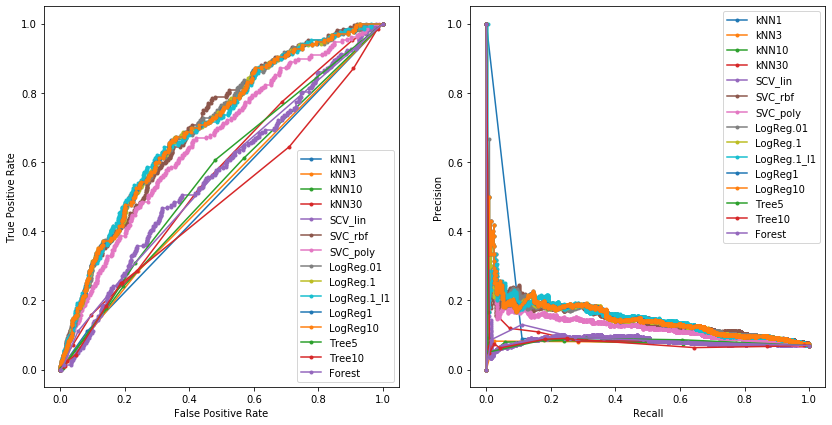

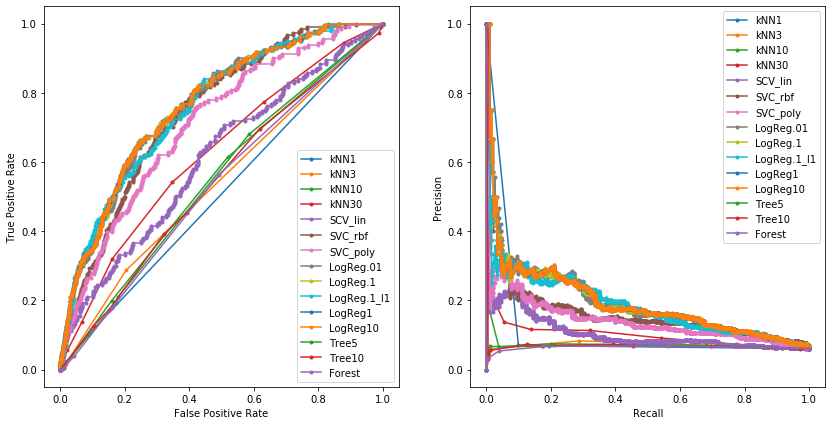

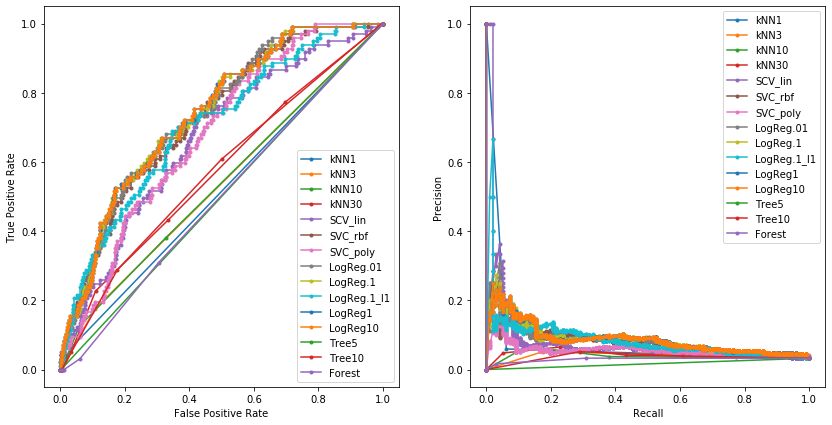

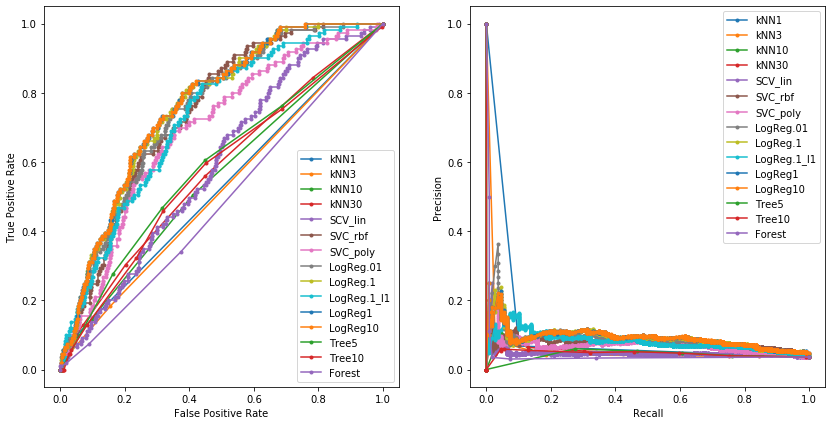

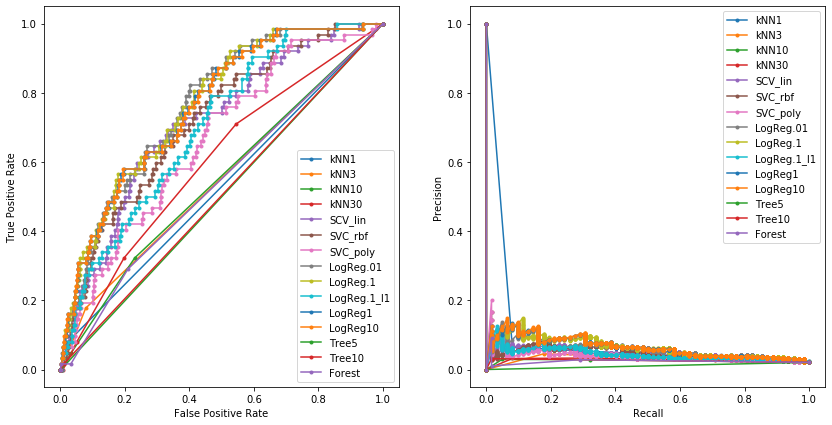

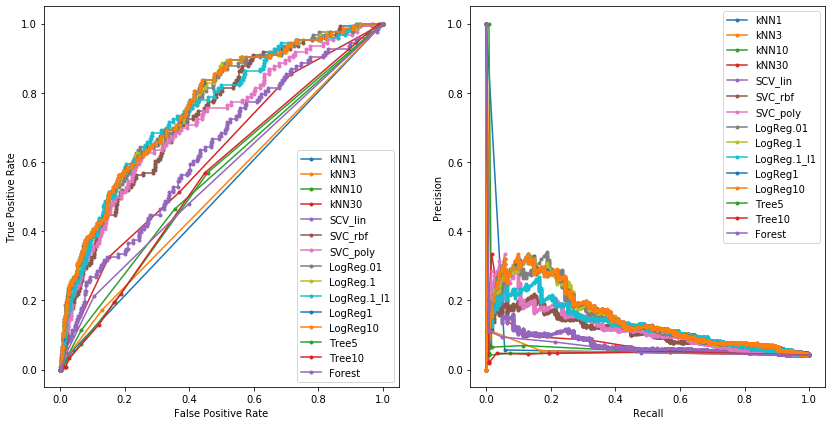

In [9]:
%%time

name_score = 'valid'


for group in tqdm_notebook(data['group'].unique()):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    data_group = data[data['group'] == group]
        
    x = data_group[names_z]
    y = data_group[name_score]

    if name_score != 'valid':
        y = (y > 0)

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, stratify=y)
    
    for name_cls, classifier in tqdm_notebook(classifiers.items(), desc=group):

        classifier.fit(x_train, y_train)

        pr = classifier.predict_proba(x_valid)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_valid, pr)
        ax1.plot(fpr, tpr, marker='.', label=name_cls)

        precision, recall, thresholds = precision_recall_curve(y_valid, pr)
        ax2.plot(recall, precision, marker='.', label=name_cls)   
        
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')

    ax1.legend()
    ax2.legend()

    fig.show()

In [11]:
name_score = 'valid'


for name_group in tqdm_notebook(data['group'].unique()):

    data_group = data[data['group'] == name_group]

    x = data_group[names_z]
    y = data_group[name_score]

    if name_score != 'valid':
        y = (y > 0)

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, stratify=y)


    classifier = LogisticRegression(C=10.0, n_jobs=-1)
    classifier.fit(x_train, y_train)

    pred = classifier.predict_proba(x_valid)[:, 1]

    fpr, tpr, thresholds_roc = roc_curve(y_valid, pred)
    precision, recall, thresholds_pr = precision_recall_curve(y_valid, pred)

    precision = precision[:-1]
    recall = recall[:-1]
    assert len(fpr) == len(tpr) == len(thresholds_roc) and len(precision) == len(recall) == len(thresholds_pr)


    index = np.argmax(tpr - fpr)
    
    threshold = thresholds_roc[index]
    fpr = fpr[index]
    tpr = tpr[index]

    pred_bin = pred > threshold
    
    cm = confusion_matrix(y_valid, pred_bin)
    precision = precision_score(y_valid, pred_bin)
    init_precision = y_valid.value_counts(normalize=True)[1]
    
    print(f'{name_score} {name_group}\nthreshold: {threshold}\ntpr: {tpr}\nfpr: {fpr}\nprecision: {precision}\ninit_precision: {init_precision}\n{cm}\n')
    

valid 18_24m
threshold: 0.03812863514831891
tpr: 0.8317307692307693
fpr: 0.49641833810888253
precision: 0.110397946084724
init_precision: 0.06933333333333333
[[1406 1386]
 [  36  172]]

valid 18_24f
threshold: 0.0612349476064941
tpr: 0.6685082872928176
fpr: 0.27704859879389854
precision: 0.13318534961154274
init_precision: 0.060333333333333336
[[2038  781]
 [  61  120]]

valid 38_44m
threshold: 0.044412338488188464
tpr: 0.5773195876288659
fpr: 0.18119187047881502
precision: 0.09466437177280551
init_precision: 0.03233333333333333
[[2377  526]
 [  42   55]]

valid 38_44f
threshold: 0.016504946446833067
tpr: 0.8807339449541285
fpr: 0.43099273607748184
precision: 0.07084265473527218
init_precision: 0.036333333333333336
[[1645 1246]
 [  14   95]]

valid 58_64m
threshold: 0.012353580563895464
tpr: 0.7741935483870968
fpr: 0.3117767188563649
precision: 0.04880581516095535
init_precision: 0.020666666666666667
[[2022  916]
 [  15   47]]

valid 58_64f
threshold: 0.02478093777826134
tpr: 0.7398373

In [57]:
def print_stat(pred, threshold, y):
    pred_bin = pred >= threshold

    cm = confusion_matrix(y, pred_bin)
    tpr = recall_score(y, pred_bin, zero_division=0)
    fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
    precision = precision_score(y, pred_bin, zero_division=0)
    init_precision = pd.value_counts(y, normalize=True)[1]

    print(f'threshold: {threshold}\ntpr: {tpr}\nfpr: {fpr}\nprecision: {precision}\ninit_precision: {init_precision}\n{cm}\n')


name_images = [path.name for path in path_images.iterdir()]

name_score = 'valid'

for name_group in tqdm_notebook(data['group'].unique()):

    data_group = data[data['group'] == name_group]

    data_train = data_group[~data_group['file_name'].isin(name_images)]
    data_test = data_group[data_group['file_name'].isin(name_images)]

    x_train = data_train[names_z].values
    y_train = data_train[name_score].values
    x_test = data_test[names_z].values
    y_test = data_test[name_score].values

    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)
    
    classifier = LogisticRegression(C=10.0, n_jobs=-1)
    classifier.fit(x_train, y_train)


    pred_valid = classifier.predict_proba(x_valid)[:, 1]
    pred_test = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds_roc = roc_curve(y_valid, pred_valid)
    precision, recall, thresholds_pr = precision_recall_curve(y_valid, pred_valid)
    precision = precision[:-1]
    recall = recall[:-1]
    assert len(fpr) == len(tpr) == len(thresholds_roc) and len(precision) == len(recall) == len(thresholds_pr)
    
    
#     index = np.argmax(tpr - fpr)
#     threshold = thresholds_roc[index]
    
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(tpr-fpr), valid')
#     print_stat(pred_valid, threshold, y_valid)
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(tpr-fpr), test')
#     print_stat(pred_test, threshold, y_test)
    
#     index = np.argmax(2 * tpr - fpr)
#     threshold = thresholds_roc[index]
    
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(2*tpr-fpr), valid')
#     print_stat(pred_valid, threshold, y_valid)
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(2*tpr-fpr), test')
#     print_stat(pred_test, threshold, y_test)
    
#     index = np.argmax(tpr - 2 * fpr)
#     threshold = thresholds_roc[index]
    
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(tpr-2*fpr), valid')
#     print_stat(pred_valid, threshold, y_valid)
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(tpr-2*fpr), test')
#     print_stat(pred_test, threshold, y_test)
    
    fpr_temp = [fpr[i] if tpr[i] > 0.95 else np.inf for i in range(len(tpr))]
    index = np.argmin(fpr_temp)
    threshold = thresholds_roc[index]
    
    print(f'score: {name_score}, group: {name_group}, threshold=arg(tpr==0.95), valid')
    print_stat(pred_valid, threshold, y_valid)
    print(f'score: {name_score}, group: {name_group}, threshold=arg(tpr==0.95), test')
    print_stat(pred_test, threshold, y_test)
    
#     precision_temp = [precision[i] if recall[i] > 0.1 else 0.0 for i in range(len(recall))]
#     index = np.argmax(precision_temp)
#     threshold = thresholds_pr[index]
    
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(precision), valid')
#     print_stat(pred_valid, threshold, y_valid)
#     print(f'score: {name_score}, group: {name_group}, threshold=argmax(precision), test')
#     print_stat(pred_test, threshold, y_test)
    
#     indexes = np.argsort(pred_test)
#     k = 8
#     indexes_good = indexes[-k:]
#     indexes_bad = indexes[:k]
#     print(pred_test[indexes_bad], pred_test[indexes_good])
#     names_good = data_test.iloc[indexes_good]['file_name'].tolist()
#     names_bad = data_test.iloc[indexes_bad]['file_name'].tolist()
#     path_good = [path_images / name for name in names_good]
#     path_bad = [path_images / name for name in names_bad]
#     images_good = [cv2.imread(str(path)) for path in path_good]
#     images_bad = [cv2.imread(str(path)) for path in path_bad]

#     pred_bin = pred > threshold
#     names_good = data_test[pred_bin]['file_name'].tolist()
#     names_bad = data_test[~pred_bin]['file_name'].tolist()
#     path_good = [path_images / name for name in names_good]
#     path_bad = [path_images / name for name in names_bad]
#     images_good = [cv2.imread(str(path)) for path in path_good]
#     images_bad = [cv2.imread(str(path)) for path in path_bad]
#     assert len(images_good) + len(images_bad) == 100
#     images_good = random.sample(images_good, 16)
#     images_bad = random.sample(images_bad, 16)

#     print('Good:')
#     fig = plt.figure(figsize=(7., 7.))
#     grid = ImageGrid(fig, 111, nrows_ncols=(4, 4))
#     for ax, im in zip(grid, images_good):
#         ax.imshow(im)
#     plt.show()

#     print('Bad:')
#     fig = plt.figure(figsize=(7., 7.))
#     grid = ImageGrid(fig, 111, nrows_ncols=(4, 4))
#     for ax, im in zip(grid, images_bad):
#         ax.imshow(im)
#     plt.show()

score: valid, group: 18_24m, threshold=arg(tpr==0.95), valid
threshold: 0.025655122990493766
tpr: 0.9516908212560387
fpr: 0.6518277234889612
precision: 0.0985985985985986
init_precision: 0.0696969696969697
[[ 962 1801]
 [  10  197]]

score: valid, group: 18_24m, threshold=arg(tpr==0.95), test
threshold: 0.025655122990493766
tpr: 1.0
fpr: 0.7083333333333334
precision: 0.05555555555555555
init_precision: 0.04
[[28 68]
 [ 0  4]]

score: valid, group: 18_24f, threshold=arg(tpr==0.95), valid
threshold: 0.0139466927445661
tpr: 0.9555555555555556
fpr: 0.7039426523297491
precision: 0.08052434456928839
init_precision: 0.06060606060606061
[[ 826 1964]
 [   8  172]]

score: valid, group: 18_24f, threshold=arg(tpr==0.95), test
threshold: 0.0139466927445661
tpr: 1.0
fpr: 0.6979166666666666
precision: 0.056338028169014086
init_precision: 0.04
[[29 67]
 [ 0  4]]

score: valid, group: 38_44m, threshold=arg(tpr==0.95), valid
threshold: 0.004468094661307648
tpr: 0.9578947368421052
fpr: 0.723478260869565

In [55]:
name_images = [path.name for path in path_images.iterdir()]

for name_group in tqdm_notebook(data['group'].unique()):
    
    data_group = data[data['group'] == name_group]

    data_train = data_group[~data_group['file_name'].isin(name_images)]
    data_test = data_group[data_group['file_name'].isin(name_images)]
        
    index_train, index_valid = train_test_split(np.arange(len(data_train)), test_size=0.3, stratify=data_train['valid'])

    x_train = data_train[names_z].iloc[index_train].values
    x_valid = data_train[names_z].iloc[index_valid].values
    x_test = data_test[names_z].values
    
    pred_bin_valid = np.ones(len(x_valid))
    pred_bin_test = np.ones(len(x_test))
    
    for name_score in names_scores[1:]:

        y_train = data_train[name_score].iloc[index_train].values
        y_valid = data_train[name_score].iloc[index_valid].values
        y_test = data_test[name_score].values
        
        if name_score != 'valid':
            y_train = (y_train > 0)
            y_valid = (y_valid > 0)
            y_test = (y_test > 0)
        
        classifier = LogisticRegression(C=10.0, n_jobs=-1)
        classifier.fit(x_train, y_train)

        pred_valid = classifier.predict_proba(x_valid)[:, 1]
        pred_test = classifier.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds_roc = roc_curve(y_valid, pred_valid)
    
        fpr_temp = [fpr[i] if tpr[i] > 0.95 else np.inf for i in range(len(tpr))]
        index = np.argmin(fpr_temp)
        threshold = thresholds_roc[index]
        
#         print(f'score: {name_score}, group: {name_group}, threshold=arg(tpr==0.95), valid')
#         print_stat(pred_valid, threshold, y_valid)
#         print(f'score: {name_score}, group: {name_group}, threshold=arg(tpr==0.95), test')
#         print_stat(pred_test, threshold, y_test)
        
        pred_bin_valid *= (pred_valid >= threshold)
        pred_bin_test *= (pred_test >= threshold)
             
    y_valid = data_train['valid'].iloc[index_valid].values
    y_test = data_test['valid'].values
        
    print(f'score: valid, group: {name_group}, threshold=arg(tpr==0.95), valid')
    print_stat(pred_bin_valid, 0.5, y_valid)
    print(f'score: valid, group: {name_group}, threshold=arg(tpr==0.95), test')
    print_stat(pred_bin_test, 0.5, y_test)

score: valid, group: 18_24m, threshold=arg(tpr==0.95), valid
threshold: 0.5
tpr: 0.8405797101449275
fpr: 0.4708650018096272
precision: 0.11796610169491525
init_precision: 0.0696969696969697
[[1462 1301]
 [  33  174]]

score: valid, group: 18_24m, threshold=arg(tpr==0.95), test
threshold: 0.5
tpr: 0.75
fpr: 0.59375
precision: 0.05
init_precision: 0.04
[[39 57]
 [ 1  3]]

score: valid, group: 18_24f, threshold=arg(tpr==0.95), valid
threshold: 0.5
tpr: 0.9055555555555556
fpr: 0.4376344086021505
precision: 0.11777456647398844
init_precision: 0.06060606060606061
[[1569 1221]
 [  17  163]]

score: valid, group: 18_24f, threshold=arg(tpr==0.95), test
threshold: 0.5
tpr: 0.75
fpr: 0.46875
precision: 0.0625
init_precision: 0.04
[[51 45]
 [ 1  3]]

score: valid, group: 38_44m, threshold=arg(tpr==0.95), valid
threshold: 0.5
tpr: 0.8947368421052632
fpr: 0.45008695652173913
precision: 0.06163886874546773
init_precision: 0.03198653198653199
[[1581 1294]
 [  10   85]]

score: valid, group: 38_44m, th